In [1]:
%matplotlib inline
from effective_quadratures.PolyParams import PolynomialParam
from effective_quadratures.PolyParentFile import PolyParent
from effective_quadratures.IndexSets import IndexSet
from effective_quadratures.Utils import column, evalfunction
import effective_quadratures.MatrixRoutines as mat
import effective_quadratures.ComputeStats as stats
from effective_quadratures.EffectiveQuadSubsampling import EffectiveSubsampling
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

<h1> The Namesake: Effective Quadrature Subsampling

In this notebook we demonstrate what effective quadrature subsampling is and how it may be used to create a polynomial approximation for a computation model. We begin by defining a simple three-dimensional function
$$f(x_1, x_2, x_3) = x_1^2 + x_2^3 + x_3$$
where $x_1, x_2, x_3$ are uniformly distributed over the cube $x_1, x_2, x_3 
\in [-1,1]$. This will be our 'expensive' computational model. 

Lets first understand what exactly effective quadrature subsampling is and how it computes the pseudospectral coefficients. Have a look at the figure below. In (a) we have a matrix of multivariate orthonormal polynomials evaluated at a tensor grid of quadrature points (rows) and the underlying polynomial basis forms the columns. This basis can be formed from either a total order or hyperbolic cross basis. The "effectively subsampled quadrature points" are obtained by computing the QR column pivoting factorization of A transpose and only taking the first n columns of A transpose as shown in (b). We then compute the coefficients by solving this as a least squares problem. When approximating computational models with noise, one may need to eliminate a few extra columns to get a good least squares approximant; as in (c) and (d). 

<img src='Matrices.png'>

To clarify the above, let us run though an example problem with the exponential function:

In [2]:
def exponential_function(x):
    return np.exp(x[0] + x[1] + x[2])

Declare the two inputs and their ranges

In [3]:
no_pts_x1 = 4
no_pts_x2 = 5
no_pts_x3 = 5
min_range = -1.0
max_range = 1.0
x1 = PolynomialParam("Uniform", min_range, max_range, [], [], [], no_pts_x1)
x2 = PolynomialParam("Uniform", min_range, max_range, [], [], [], no_pts_x2)
x3 = PolynomialParam("Uniform", min_range, max_range, [], [], [], no_pts_x3)
x1x2x3 = []
x1x2x3.append(x1)
x1x2x3.append(x2)
x1x2x3.append(x3)

We will opt for a hyperbolic cross basis, though one can also opt for a total order basis. Bear in mind that we are trying to escape the cost associated with a more conventional tensor grid or sparse grid basis. A hyperbolic cross takes in a *q* parameter. When *q=1* we have a total order basis. Note that the cardinality of the hyperbolic cross sets the maximum number of function evaluations required. 

In [4]:
q = 0.6
hyperbolic_cross = IndexSet("hyperbolic cross", [no_pts_x1, no_pts_x2, no_pts_x3], q)
maximum_number_of_evals = IndexSet.getCardinality(hyperbolic_cross)
print maximum_number_of_evals

24


Lets plot this index set which has 16 terms:

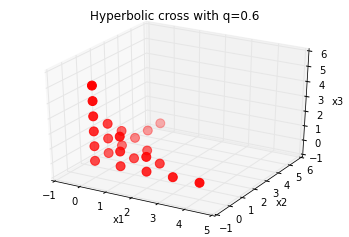

In [5]:
indexset = IndexSet.getIndexSet(hyperbolic_cross)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(column(indexset,0), column(indexset,1), column(indexset,2) , marker='o', s=80, color='red');
ax.set_xlabel('x1');
ax.set_ylabel('x2');
ax.set_zlabel('x3');
plt.title('Hyperbolic cross with q=0.6');

The class Effective_Subsampling has holds all the function calls required for effective quadrature subsampling. We begin by declaring an EffectiveSubsampling object that takes as inputs the uncertain parameters, the index set and a derivative flag. In this notebook as derivatives are not considered the derivative flag is set to 0.

In [6]:
effectiveQuads = EffectiveSubsampling(x1x2x3, hyperbolic_cross, 0)
A_tall, esquad_pts, esquad_wts = EffectiveSubsampling.getAsubsampled(effectiveQuads, maximum_number_of_evals)
A_tall, normalizations = mat.rowNormalize(A_tall)

Now, lets evaluate our model at the effectively subsampled quadrature points

In [7]:
b_tall = np.diag(esquad_wts) * np.mat(evalfunction(esquad_pts, exponential_function))
b_n = np.dot(normalizations, b_tall)

Let's plot where these subsamples lie on our existing [no_pts_x1, no_pts_x2, no_pts_x3] tensor grid. 

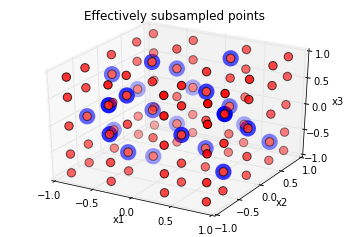

In [8]:
uqProblem = PolyParent(x1x2x3, "tensor grid")
tensor_pts, wts = PolyParent.getPointsAndWeights(uqProblem)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tensor_pts[:,0], tensor_pts[:,1], tensor_pts[:,2], s=70, c='r', marker='o');
ax.scatter(esquad_pts[:,0], esquad_pts[:,1], esquad_pts[:,2], s=150, facecolor='none', edgecolor='b', marker='o', lw=4);
ax.set_xlabel('x1');
ax.set_ylabel('x2');
ax.set_zlabel('x3');
plt.title('Effectively subsampled points');

Now we solve the least squares problem:

In [9]:
xn = mat.solveLeastSquares(A_tall, b_n)
print xn[0:10]

[[  4.43191905e+00]
 [  2.46996583e+00]
 [  6.48781719e-01]
 [  1.93925917e-01]
 [  7.93629989e-02]
 [ -1.05407469e-14]
 [  2.29296303e+00]
 [  1.04775798e+00]
 [  3.60070910e-01]
 [  4.48110303e-01]]


So how does this coefficient approximation fare with a randomized sampling approach? 

In [10]:
x_full, i, f = PolyParent.getCoefficients(uqProblem, exponential_function)
print x_full[0,0]
#error = np.linalg.norm(x_full[0:maximum_number_of_evals] - xn, 2)
#print error

1.62306763168
